#Ex. 11: Unsupervised learning

Unsupervised learning algorithms can learn patterns about the input data when there is **no** output variable associated to each observation (e.g. membership to a particular class, like a type of cancer, or a continuous variable, such as the catalytic rate of an enzyme). Unsupervised learning methods can help us to explore the data and identify patterns in it.

In this exercise, we will explore data using two different kinds of unsupervised learning approaches:
* **Clustering**, where we group observations (with no prior knowledge of possible groups) such that objects in the same group (called a cluster) are more similar to each other than to those in other groups.
* **Dimensionality reduction**, where we transform a dataset from a high-dimensional space into a low-dimensional space that retains meaningful properties of the original data.

The exercise uses proteomics and phosphoproteomics data from different types of breast cancer, as well as some samples from healthy patients.

*Proteogenomics connects somatic mutations to signalling in breast cancer, Mertins *et al.*, Nature, 2016
https://www.nature.com/articles/nature18003


In [3]:
#@markdown ##0. Setup
#@markdown Prepare the environment for the exercise:

#@markdown - Remove Google Colab sample data
!rm -rf sample_data

#@markdown - Download data
# Sample PAM50 status
!wget https://gist.githubusercontent.com/miguelcorrea/90197ff2c47fec792b01792f99895ff7/raw/b1eac19cecd9ad6f466005e671a27750b8fc0787/sample_pam50_status.csv
# PAM50 genes (provisional file)
!wget https://gist.githubusercontent.com/miguelcorrea/d352ba62acddb90f5f40c7ccb319a2b2/raw/149cbcbd88c50268c2f3274fbcbed277022898ec/pam50_idxs.txt
# PAM50 status legend
!wget https://user-images.githubusercontent.com/11046487/229552779-c85fbef2-fd4a-40c6-9a24-c91707825693.png
!mv 229552779-c85fbef2-fd4a-40c6-9a24-c91707825693.png pam50_legend.png
# Proteome data
!wget https://gist.githubusercontent.com/miguelcorrea/b793faf39534d881a4021ff64e224e2c/raw/f524b34ad40c3d6d4c7e6005f47ce2bf697031f8/proteome_data.csv
# Phosphoproteome data
!wget https://gist.githubusercontent.com/miguelcorrea/f2b113af3cf5bd6be4aadaee6578a2cc/raw/6d87c05bb56b9854a934cb5481733dacb62fe48a/phosphoproteome_data.csv

#@markdown - Import libraries
from random import seed
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns

#@markdown - Set random seed for reproducibility
seed(42)

#@markdown - Define auxiliary functions
def get_sample_to_pam50(status_df):
    """
    Return a dictionary associating each sample with its PAM50 status
    """
    sample_to_pam50 = {}
    for idx, row in status_df.iterrows():
        sample_name = row.name
        pam50 = row["PAM50"]
        sample_to_pam50[sample_name] = pam50
            
    return sample_to_pam50

def drop_nan_features(df, threshold=.5):
  """Drop features with a fraction of missing values above a given threshold"""
  assert 0 < threshold < 1
  return df.loc[:, df.isnull().mean() < threshold]

def knn_imputation(df, n_neighbors=5):
  imputer = KNNImputer(weights="distance", n_neighbors=n_neighbors)
  arr = imputer.fit_transform(df)
  feature_names = imputer.get_feature_names_out()
  index = df.index
  imputed_df = pd.DataFrame(arr,columns=feature_names,index=index)
  return imputed_df

def get_phospho_subset_columns(phospho_df,pam50_ids):
  """
  Drop columns with information about phosphosites that are not present in PAM50
  """

  to_drop = []
  columns = list(phospho_df.columns)
  for column in columns:
    a, b, *_ = column.split("_")
    prot_id = "_".join([a,b])
    if prot_id not in pam50_ids:
      to_drop.append(column)

    pam50_phospho_df = phospho_df.drop(to_drop, axis=1)
    return pam50_phospho_df


#@markdown - Read input data
# Table containing log2 ITRAQ values for the proteome
proteome_df = pd.read_csv("proteome_data.csv", index_col=0)
# Table containing log2 ITRAQ values for the phosphoproteome
phospho_df = pd.read_csv("phosphoproteome_data.csv", index_col=0)
# Table containing the status of each sample
sample_status_df = pd.read_csv("sample_pam50_status.csv",index_col=0)
# RefSeq IDs of PAM50 genes
# TODO: fix the filename
with open("pam50_idxs.txt") as f:
    pam50_ids = [x.strip() for x in f.readlines()]

sample_to_pam50 = get_sample_to_pam50(sample_status_df)
pam50_status = [sample_to_pam50[sample] for sample in proteome_df.index]
    


--2023-05-07 20:15:21--  https://gist.githubusercontent.com/miguelcorrea/90197ff2c47fec792b01792f99895ff7/raw/b1eac19cecd9ad6f466005e671a27750b8fc0787/sample_pam50_status.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4346 (4.2K) [text/plain]
Saving to: ‘sample_pam50_status.csv’

sample_pam50_status 100%[===================>]   4.24K  --.-KB/s    in 0s      

2023-05-07 20:15:21 (16.4 MB/s) - ‘sample_pam50_status.csv’ saved [4346/4346]

--2023-05-07 20:15:21--  https://gist.githubusercontent.com/miguelcorrea/d352ba62acddb90f5f40c7ccb319a2b2/raw/149cbcbd88c50268c2f3274fbcbed277022898ec/pam50_idxs.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubuse

## 1. Data preparation

For various reasons, real-world data often has missing values. Such missing values are incompatible with most machine learning methods, which assume that all values in an array have meaningful numerical values. A simple strategy to deal with incomplete datasets is to simply discard observations or variables which contain missing values. This comes at the price of losing potentially valuable data. A better strategy is to impute the missing values.

Here we use k-nearest neighbours imputation, in which the $k$ nearest neighbours of an observation are used to fill in the blanks. First, we remove
columns with >50% missing values, as they probably contain too little information anyway.



In [4]:
# Create a new dataframe manually filling in sample status
proteome_init_cols = proteome_df.shape[1] 
phospho_init_cols = phospho_df.shape[1]

# Drop proteins and phosphosites for which >50% of the samples have missing
# values
print("Dropping columns with >50% missing values...")
proteome_df = drop_nan_features(proteome_df,threshold=.5)
print(f"Dropped {proteome_init_cols - proteome_df.shape[1]} columns in the proteome dataframe")
print(f"{proteome_df.shape[1]} columns left")

phospho_df = drop_nan_features(phospho_df,threshold=.5)
print(f"Dropped {phospho_init_cols - phospho_df.shape[1]} columns in the phosphoproteome dataframe")
print(f"{phospho_df.shape[1]} columns left")

# Perform kNN imputation
proteome_df = knn_imputation(proteome_df)
phospho_df = knn_imputation(phospho_df)

Dropping columns with >50% missing values...
Dropped 1031 columns in the proteome dataframe
11522 columns left
Dropped 38108 columns in the phosphoproteome dataframe
24571 columns left


Then we will also prepare datasets containing -only- genes used to build the PAM50 cancer signature, 6 of which appear to be missing in this dataset.

In [5]:
# Prepare dataframes with -only- the proteins that are used in the PAM50
# assignment
pam50_proteome_df = proteome_df.drop(columns=proteome_df.columns.difference(pam50_ids))
pam50_phospho_df = get_phospho_subset_columns(phospho_df, pam50_ids)

# 2. Reconstructing the PAM50 status
PAM50 is a 50-gene signature that classifies breast cancer into five molecular subtypes, according to their gene expression:

* Basal-like
* Luminal A
* Luminal B
* HER2-enriched
* Normal-like

**Can you reconstruct this signature using proteomics & phosphoproteomics data, rather than the gene expression data it was constructed with?**

To measure the agreement between your clustering and the original PAM50 signature, we will use the *adjusted mutual information*. If your clustering and the PAM50 signature are in perfect agreement, the adjusted mutual information will be 1. If the agreement equals the value that would be expected due to mere chance, the value is 0.

**Note**: this metric is independent of the values of the labels: a permutation of the cluster label values will not change the score value. It is also symmetric: the value of AMI(X,Y) is the same as AMI(Y,X).



## 2.1 K-means

To start with, we will use the K-means algorithm.

**K-means requires pre-specifying the number of desired clusters. If you want to replicate the PAM50 signature, how many clusters would you need?**

In [ ]:
nr_pam50_clusters = ...

**Now try clustering using all of the proteome & phosphoproteome data. An example illustrating how to do it is given for the proteome data.** 

**Tip**: Since you are going to do similar things repeatedly, write a function to perform clustering & calculate the adjusted mutual information score.

In [ ]:
# Using proteome data
clusterer = KMeans(n_clusters=nr_pam50_clusters, init="random", n_init=10)
clusterer.fit(proteome_df)
proteome_ami = adjusted_mutual_info_score(clusterer.labels_, pam50_status)
print(proteome_ami)

In [ ]:
# Using phosphoproteome data

**Now try doing the same, but using only data pertaining to the genes used to build the PAM50 signature.**


In [ ]:
# Using PAM50 proteome data

0.45838130559241846


In [1]:
# Using PAM50 phosphoproteome data

**What do you observe? Why is there no perfect agreement?** 

In [2]:
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y=["Full proteome","Full phosphoproteome","Proteome (PAM50)", "Phosphoproteome (PAM50)"],
            x=[proteome_ami, phospho_ami, proteome_pam50_ami, phospho_pam50_ami], ax=ax)

ax.set_xlabel("Adjusted mutual information")
sns.despine()

NameError: ignored

## 2.2 Hierarchical clustering

Let's also now try with hierarchical clustering. Try clustering the the dataset that matched the PAM50 classification best when using k-means.

**Hierarchical clustering requires you to specifiy a distance metric between samples. Which could be good metrics in this case?**

Tip: You may want to refer to the documentation of the function used to calculate pairwise distances under the hood: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

In [ ]:
#@markdown Create a colour palette to indicate the PAM50 classification
palette = sns.color_palette("tab10",5)

status_to_color = {'Her2':palette[0],
                  'Basal':palette[1],
                  'LumA':palette[2],
                  'LumB':palette[3],
                  'Normal':palette[4]}

row_colors = []
for status in pam50_status:
  row_colors.append(status_to_color[status])


The following code shows an example of how we can use hierarchical clustering for this dataset.

In [ ]:
metric = ...?
# Cluster the data by rows (e.g. samples)
row_linkage = sp.cluster.hierarchy.linkage(pam50_proteome_df, method='complete', metric=metric)
# Transpose the dataframe to cluster the features as well
col_linkage = sp.cluster.hierarchy.linkage(pam50_proteome_df.T, method='complete', metric=metric)

You can visualize the clustering of both samples and features using the clustermap function. What does the clustermap indicate?

The colors on the rows indicate the PAM50 status of the sample (see the following legend).

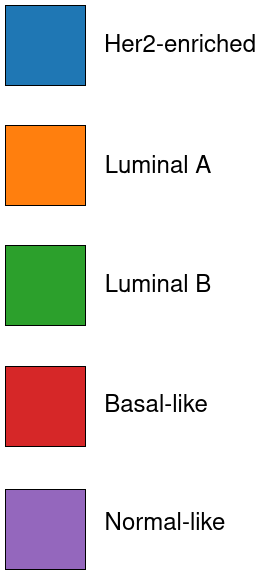

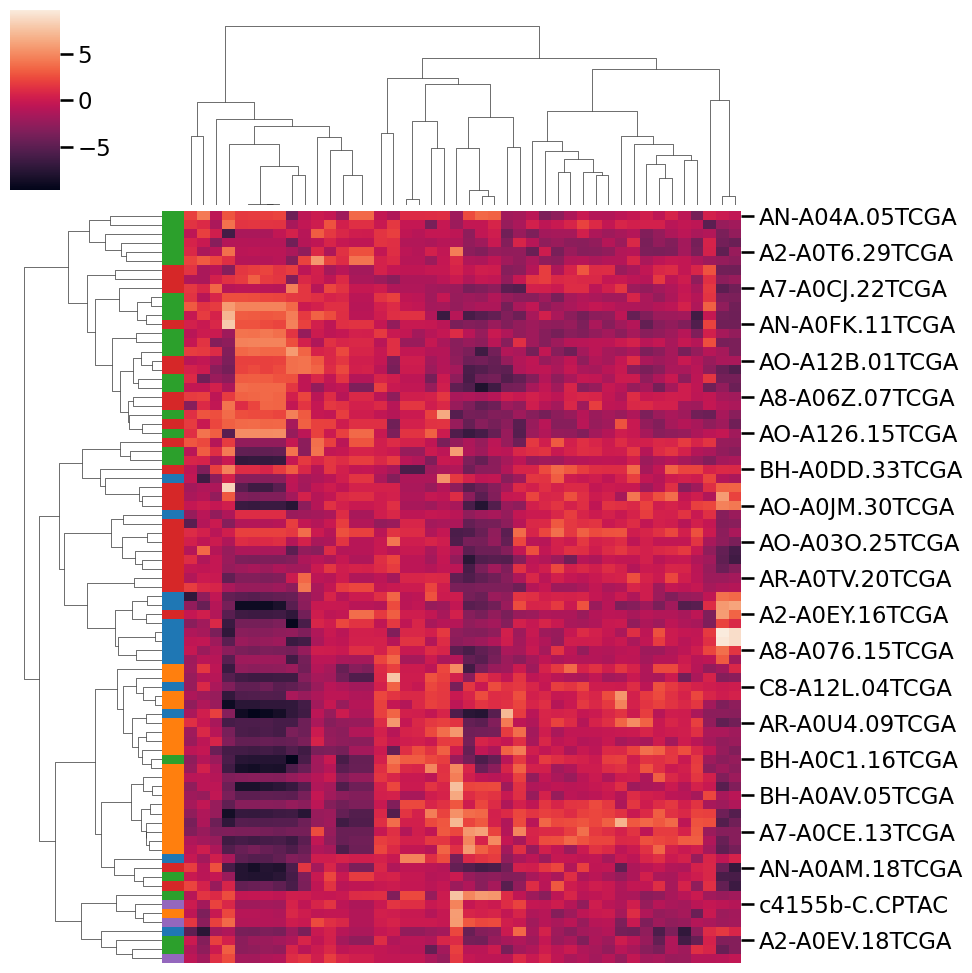

In [ ]:
sns.clustermap(pam50_proteome_df,
               row_linkage=row_linkage, col_linkage=col_linkage,
               row_colors=row_colors,xticklabels=[])


The following snippet of code shows how you can cut the tree to give a certain number of clusters. How does it perform compared to k-means?

In [ ]:
cut_tree = sp.cluster.hierarchy.cut_tree(row_linkage, 5)
cluster_membership = np.reshape(cut_tree, (cut_tree.shape[0]))
adjusted_mutual_info_score(cluster_membership, pam50_status)

0.3938764325499017

You can also plot just the dendrogram (*ignore the automated colouring scheme that scipy uses*) and experiment with cutting the tree at different heights. How does the number of clusters vary as you change the threshold?

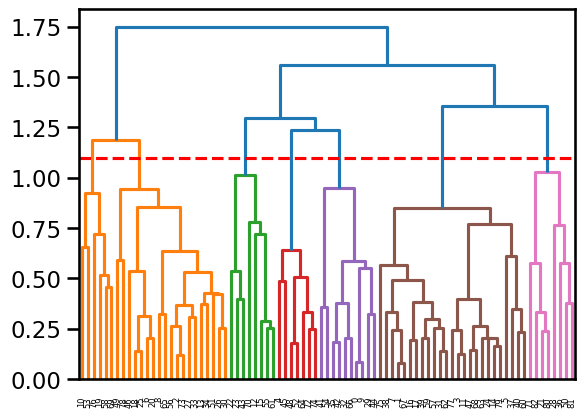

In [ ]:
dendrogram = sp.cluster.hierarchy.dendrogram(row_linkage)
cutting_height = 1.1
plt.axhline(cutting_height,color='red',ls='--')

##3. Dimensionality reduction
Let's now try to create our own clustering of the cancer data using both proteome and phosphoproteome data. Since the dimensionality of the resulting data will be very high, let's reduce it using PCA.



In [ ]:
# Join dataframes
df = proteome_df.join(phospho_df)
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(df)
# Put through PCA
# Do k-means; silhouette plot to decide which k is best
# Plot resulting clustering on the 2-dimensional space
# Which variables explain most variance? What do they do? 
# Does this explain why each observation is put in each cluster?

We can then plot the principal components and see how the points are distributed according to their PAM50 status. **What do you observe and how does it relate to previous exercises?**

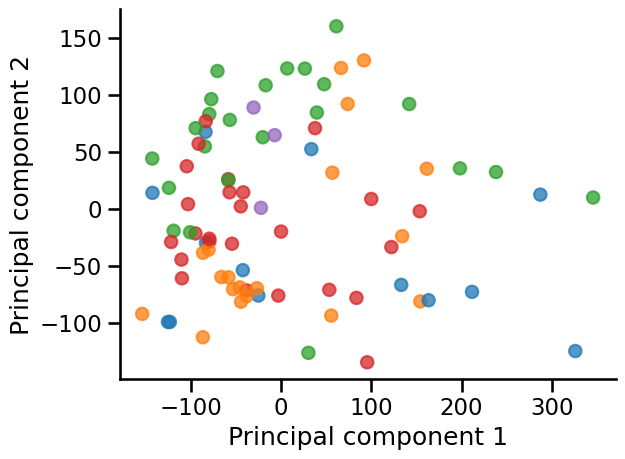

In [ ]:
sns.set_context('talk')
plt.scatter(reduced_df[:,0],reduced_df[:,1],alpha=.75,color=row_colors)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
sns.despine()

**How much of the variance in the data is explained by the PCA? How much by each component?**

In [ ]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.16658979 0.06988379]
0.23647357773577965


Let's now try clustering with K-means on the data with reduced dimensionality. The code below will take of clustering and plotting the samples according to their assigned clusters, as well as the cluster centroids (marked a black Xs).

**Try some different numbers of clusters and observe the results. What do you think would be a reasonable number of clusters?**

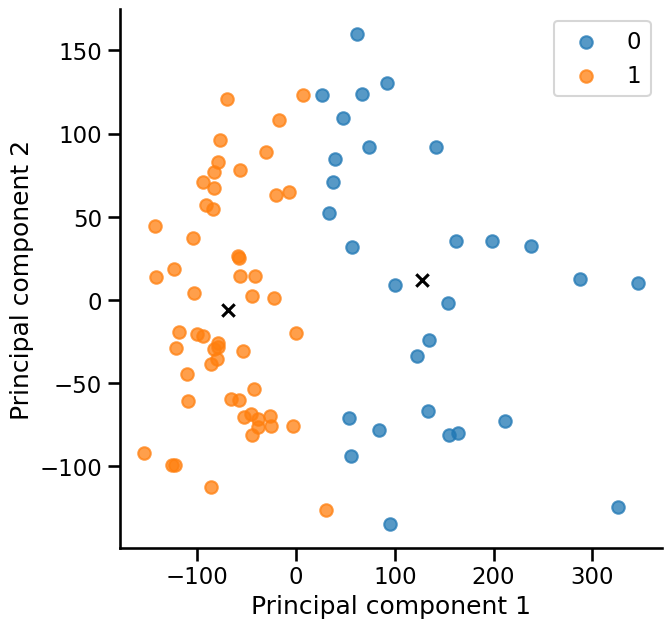

In [ ]:
# Clustering
n_clusters = 2
clusterer = KMeans(n_clusters=n_clusters, init="random", n_init=10)
labels = clusterer.fit_predict(reduced_df)
clustering_df = pd.DataFrame(reduced_df, columns=["PC1","PC2"])
clustering_df['cluster_labels'] = labels.tolist()
unique_labels = np.unique(labels)
centroids = clusterer.cluster_centers_

# Plotting
plt.figure(figsize=(7,7))
for i in unique_labels:
  subset_df = clustering_df.loc[clustering_df["cluster_labels"] == i]
  plt.scatter(subset_df["PC1"], subset_df["PC2"],alpha=.75, label=i)

plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k',marker='x')

plt.legend(loc='best')
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
sns.despine()



We can use metrics to evaluate the quality of our clustering. Since we are trying to discover new ways of grouping our samples, there is no ground truth to compare against: we need some other way of deducing whether our clustering is any good. One property that is desirable from a clustering assignment is for samples within a cluster to be similar (close) to each other, and noticeably different (distant) from other clusters.

The Silhouette coefficient reflects this property, and we will use it in this exercise to evaluate clustering quality. The Silhoutte coefficient is a per-sample metric calculated as:

$S = \frac{(b - a)}{\max(a,b)}$

where $a$ is the mean intra-cluster distance and $b$ is the mean nearest-cluster distance. 

The Silhouette coefficient ranges between [-1,1], where -1 is the worst score and 1 is the best (dense, well separated clusters). Values around 0 indicate overlapping clusters. Negative values usually indicate that samples have been assigned to the wrong cluster, because a different cluster is actually more similar.

In the following plots, the y axis indicates the index of each sample for each cluster label and the x axis its corresponding silhouette coefficient. The red discontinuous line indicates the average Silhouette coefficient over all clusters.

**Try different numbers of clusters. What would be a reasonable pick? You can judge based on criteria like:**
* **Average silhouette coefficient over clusters**
* **Presence of clusters with below average silhouette coefficients**
* **Fluctuations within clusters**



For n_clusters = 2, the average silhouette score is : 0.47002035278590204
For n_clusters = 3, the average silhouette score is : 0.43918651946439013
For n_clusters = 4, the average silhouette score is : 0.38189312375793694
For n_clusters = 5, the average silhouette score is : 0.38241056307208593
For n_clusters = 6, the average silhouette score is : 0.38123763251527815


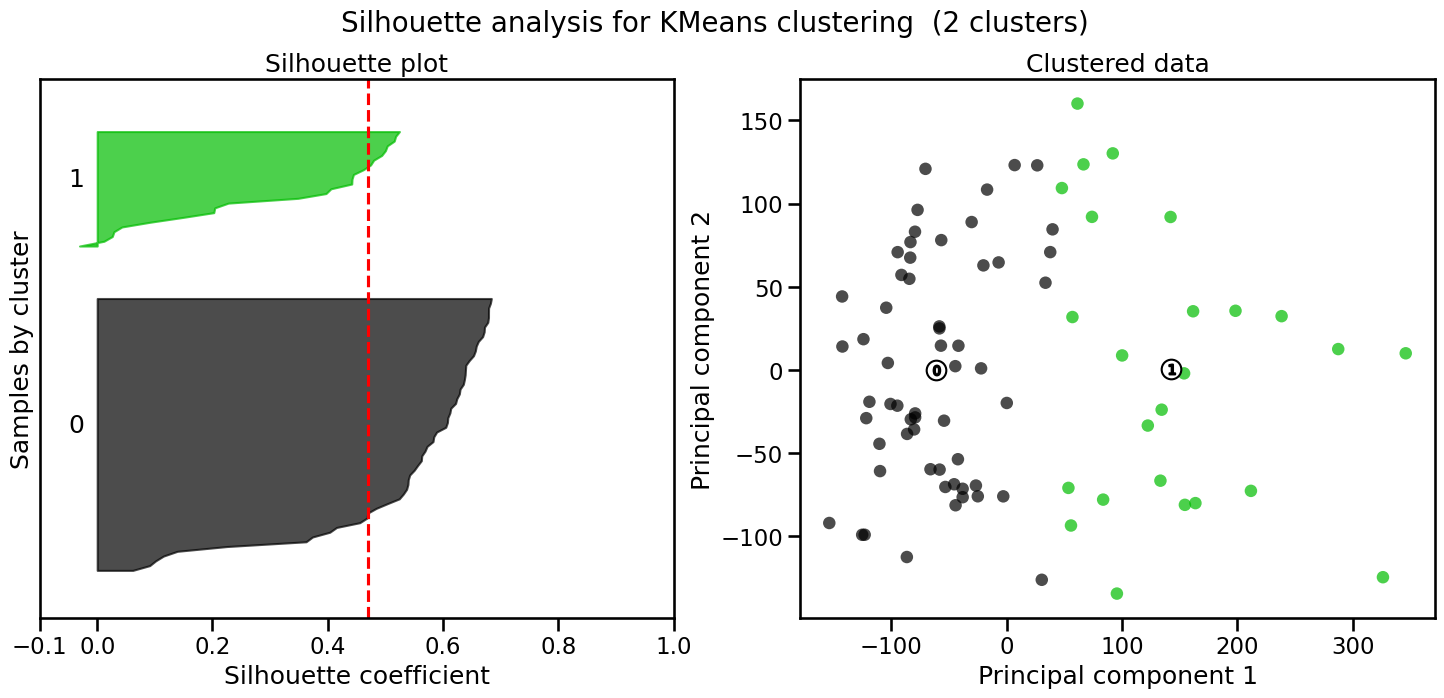

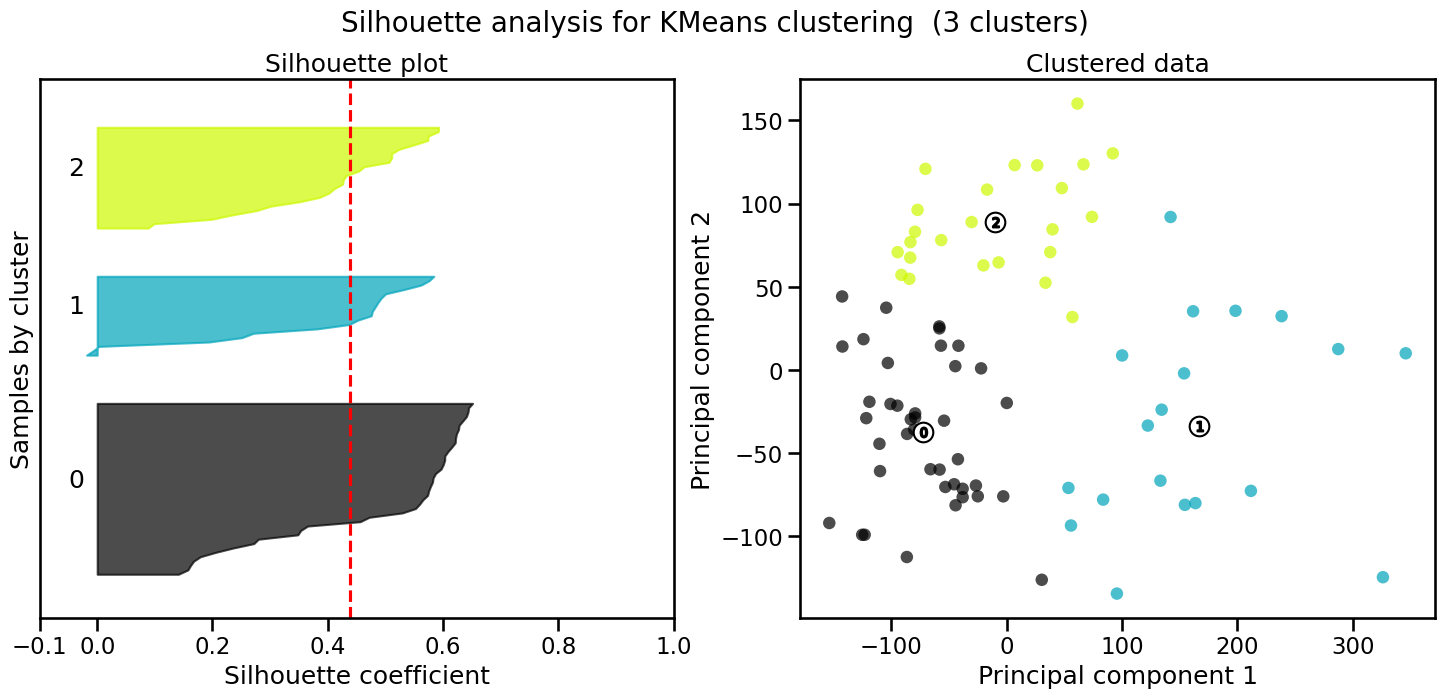

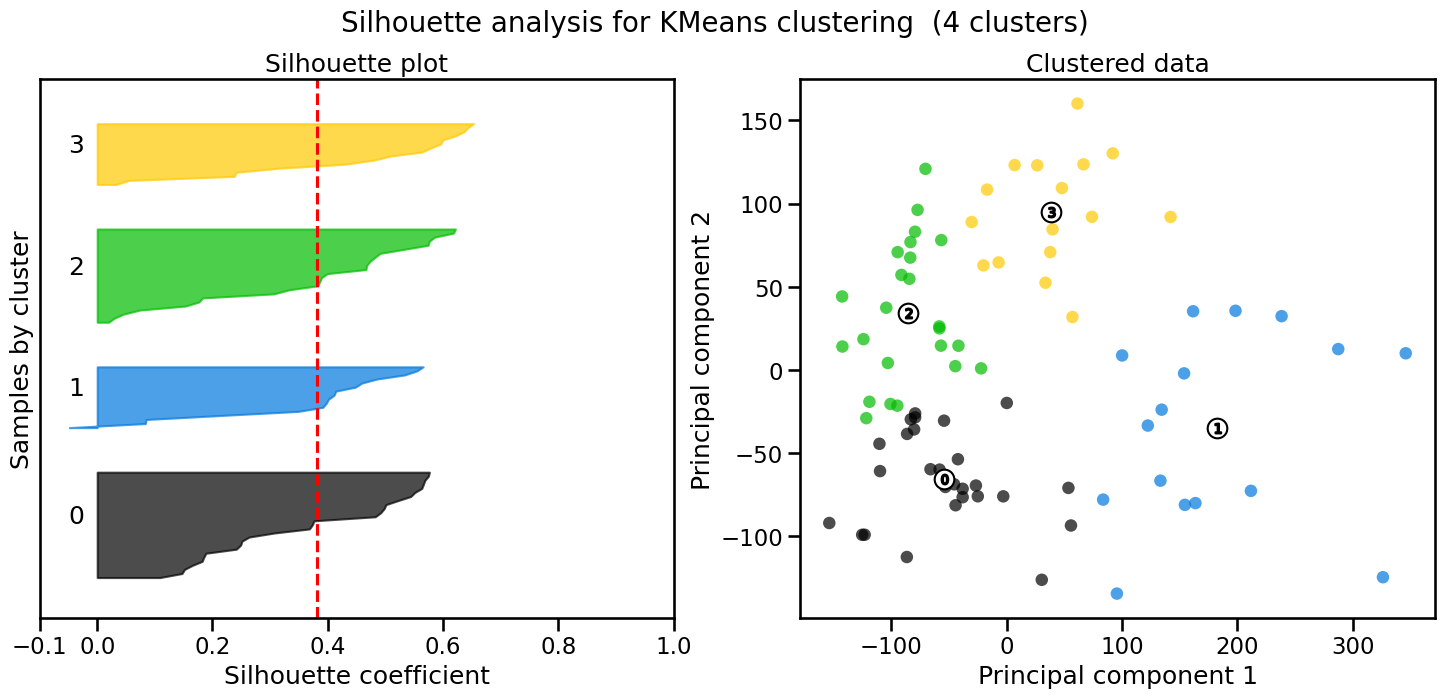

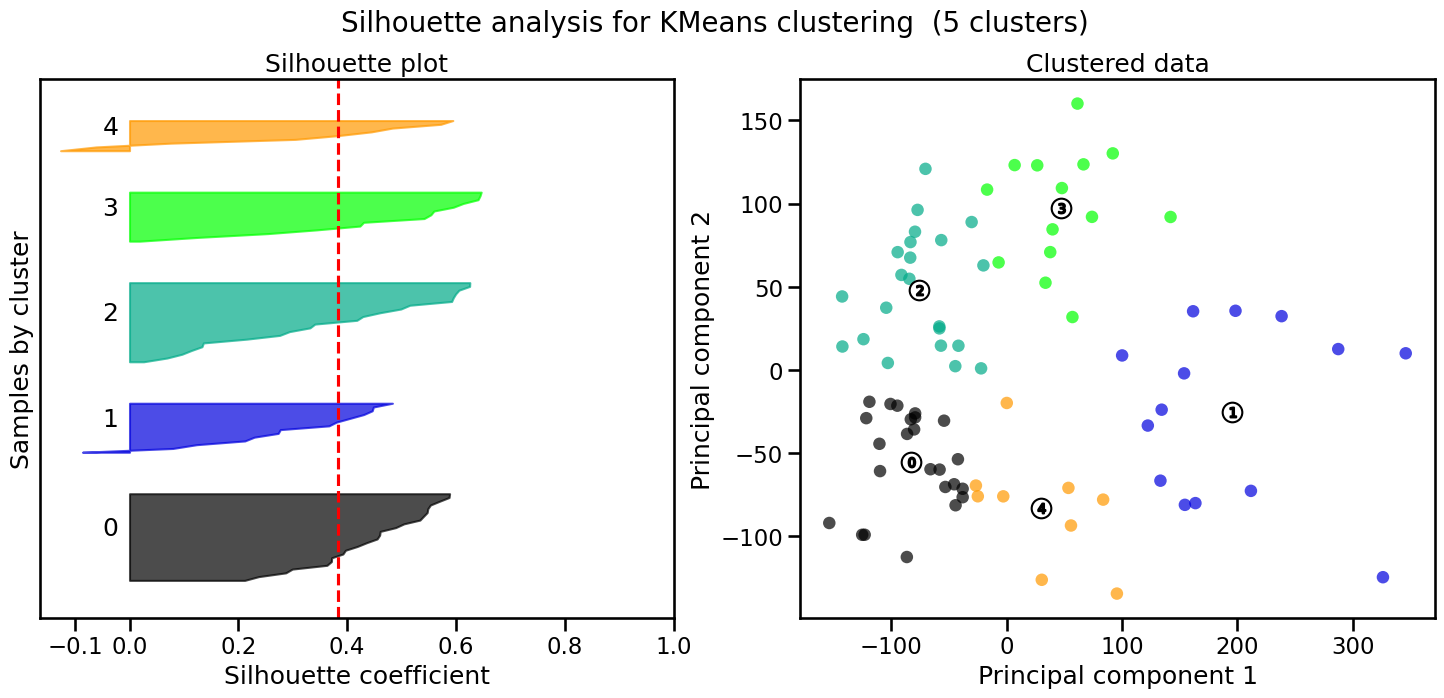

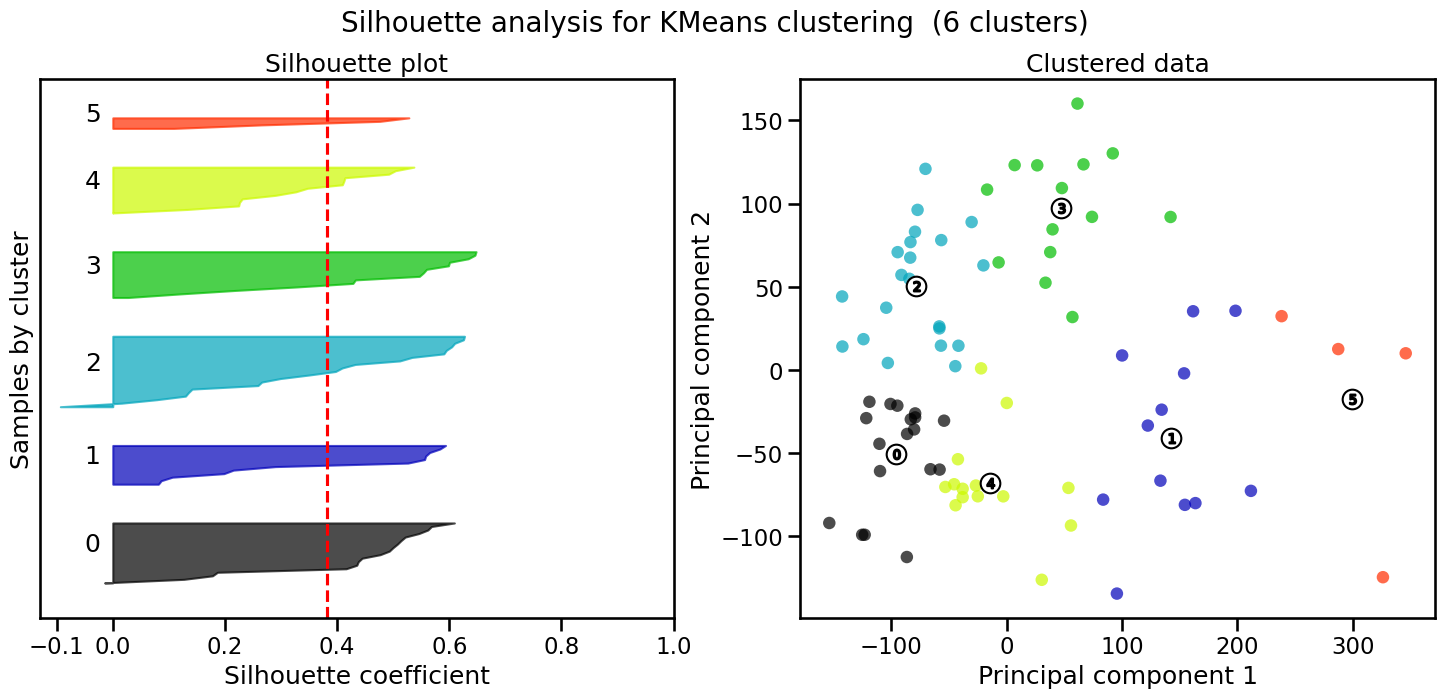

In [ ]:
# Silhoutte score stuff

range_n_clusters = [2,3,4,5,6]

for n_clusters in range_n_clusters:

  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(18, 7)
  
  ax1.set_ylim([0, len(reduced_df) + (n_clusters + 1) * 10])
  clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
  cluster_labels = clusterer.fit_predict(reduced_df)

  # Average silhouette score over all clusters  
  silhouette_avg = silhouette_score(reduced_df, cluster_labels)
  print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")
  
  sample_silhouette_values = silhouette_samples(reduced_df, cluster_labels)
  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  # Axis 1: silhouette plot
  ax1.set_title("Silhouette plot")
  ax1.set_xlabel("Silhouette coefficient")
  ax1.set_ylabel("Samples by cluster")

  # Vertical line indicates average silhouette score over all values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # Axis 2: cluster visualization
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(reduced_df[:, 0], reduced_df[:, 1], lw=0, alpha=0.7, c=colors, edgecolor="k")

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centroids
  ax2.scatter(
      centers[:, 0],
      centers[:, 1],
      marker="o",
      c="white",
      alpha=1,
      s=200,
      edgecolor="k")

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Clustered data")
    ax2.set_xlabel("Principal component 1")
    ax2.set_ylabel("Principal component 2")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering  ({n_clusters} clusters)",
        fontsize=20)

  